[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/dbsn-import/blob/main/notebooks/townhalls_dbsn.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/dbsn-import/blob/main/notebooks/townhalls_dbsn.ipynb)

# Finding missing town halls in Italy

## Step 1: State Of The Art analysis

### Configuration

In [307]:
SEARCH_AREA_ID = 3600365331 # Italia
#SEARCH_AREA_ID = 3600042611 # Emilia-Romagna
#SEARCH_AREA_ID = 3600040218 # Campania
# ID calculated with https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_element_id

In [308]:
PROVINCES_FILE_PATH = f"./provinces_{SEARCH_AREA_ID}.4326.parquet"
MUNICIPALITIES_FILE_PATH = f"./municipalities_{SEARCH_AREA_ID}.4326.parquet"
TOWNHALLS_FILE_PATH = f"./townhalls_{SEARCH_AREA_ID}.4326.parquet"
BAD_TOWNHALLS_FILE_PATH = f"./bad_townhalls_{SEARCH_AREA_ID}.4326.geojson"
WITHOUT_TOWNHALL_FILE_PATH = f"./without_townhall_{SEARCH_AREA_ID}.4326.geojson"
DBSN_FILE_PATH = f"./dbsn_townhalls.geojson"
DBSN_CONFLICTS_FILE_PATH = f"./dbsn_conflicts_{SEARCH_AREA_ID}.4326.geojson"
DBSN_MISSING_FILE_PATH = f"./dbsn_missing_{SEARCH_AREA_ID}.4326.geojson"
UNTAGGED_FILE_PATH = f"./untagged_{SEARCH_AREA_ID}.4326.geojson"
UNTAGGED_MISSING_FILE_PATH = f"./untagged_missing_{SEARCH_AREA_ID}.4326.geojson"

### Setup

In [309]:
%pip install geopandas contextily pyproj rtree shapely mapclassify branca folium

Note: you may need to restart the kernel to use updated packages.


In [310]:
from pandas import merge, Series
from geopandas import GeoDataFrame, read_file, read_parquet
from shapely.geometry import GeometryCollection, shape, Point, MultiPolygon, LineString
from shapely.ops import polygonize
from urllib.request import urlopen, urlretrieve
from urllib.error import HTTPError
from urllib.parse import quote_plus
from os.path import exists
import contextily as cx
import json
from numpy import array
from os import system

### Download municipalities and existing town halls from Overpass

In [311]:
PROVINCE_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({SEARCH_AREA_ID})->.searchArea;
(
    relation["boundary"="administrative"]["admin_level"="6"]["ISO3166-2"!="FR-74"](area.searchArea);
    relation["boundary"="administrative"]["admin_level"="4"]["ISO3166-2"="IT-23"](area.searchArea);
);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [312]:
MUNICIPALITY_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({SEARCH_AREA_ID})->.searchArea;
relation["boundary"="administrative"]["admin_level"="8"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [313]:
TOWNHALL_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({SEARCH_AREA_ID})->.searchArea;
nwr["amenity"="townhall"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [314]:
def fetchOverpassGeoDataFrame(overpass_query:str, geometry_transform=shape):
    url = "https://overpass-api.de/api/interpreter?data="+quote_plus(overpass_query)
    try:
        with urlopen(url) as response:
            data = response.read()
            encoding = response.info().get_content_charset('utf-8')
            json_content = data.decode(encoding)
        if "Query timed out" in json_content:
            raise Exception("Query timed out")
        #print(json_content)
        json_object = json.loads(json_content)
        #print(json_object['elements'][0] if json_object['elements'] else "No elments")
        elements = [{
            "id": element["id"],
            "osm_id": element["tags"]["_osm_id"],
            "osm_type": element["tags"]["_osm_type"],
            "osm_url": 'https://www.openstreetmap.org/'+element["tags"]["_osm_type"]+'/'+element["tags"]["_osm_id"],
            "name": element["tags"]["name"] if "name" in element["tags"] else None,
            "geometry": geometry_transform(element['geometry'])
        } for element in json_object['elements']]
        #print(elements[0])
        # OSM uses WGS 84: https://wiki.openstreetmap.org/wiki/Converting_to_WGS84
        crs = 'EPSG:4326' # Use the SRID for WGS 84 - https://epsg.io/4326
        gdf = GeoDataFrame(elements, crs=crs)
    except HTTPError as err:
        print("Failed downloading data from Overpass, retry later")
        raise err
    except json.JSONDecodeError as err:
        print("Failed interpreting JSON data from Overpass")
        raise err
    return gdf

In [315]:
def readOrFetchOverpassGeoDataFrame(file_path:str, overpass_query:str, geometry_transform=shape):
    if exists(file_path):
        if file_path.endswith(".parquet"):
            gdf = read_parquet(file_path)
        else:
            gdf = read_file(file_path, driver='GeoJSON')
    else:
        gdf = fetchOverpassGeoDataFrame(overpass_query, geometry_transform)
        if file_path.endswith(".parquet"):
            gdf.to_parquet(file_path)
        else:
            gdf.to_file(file_path, driver='GeoJSON')
    return gdf

In [316]:
# Convert Overpass geometries into MultiPolygons - https://stackoverflow.com/a/72677231/2347196
convert_geom_to_multipolygon = lambda x: MultiPolygon(polygonize(shape(x)))

In [317]:
province_gdf = readOrFetchOverpassGeoDataFrame(PROVINCES_FILE_PATH, PROVINCE_OVERPASS_QUERY, convert_geom_to_multipolygon)
province_gdf.count()

id          110
osm_id      110
osm_type    110
osm_url     110
name        110
geometry    110
dtype: int64

In [318]:
province_gdf.head()

id    osm_id  osm_type                                          osm_url  \
0   1     39151  relation     https://www.openstreetmap.org/relation/39151   
1   2     39979  relation     https://www.openstreetmap.org/relation/39979   
2   3     40021  relation     https://www.openstreetmap.org/relation/40021   
3   4    276369  relation    https://www.openstreetmap.org/relation/276369   
4   5  12998776  relation  https://www.openstreetmap.org/relation/12998776   

                 name                                           geometry  
0           Agrigento  MULTIPOLYGON (((13.98172 37.19299, 13.98217 37...  
1               Nuoro  MULTIPOLYGON (((9.62535 40.25649, 9.62514 40.2...  
2  Aristanis/Oristano  MULTIPOLYGON (((8.38245 40.33860, 8.38324 40.3...  
3            Cagliari  MULTIPOLYGON (((9.16386 39.83254, 9.16450 39.8...  
4   Sulcis Iglesiente  MULTIPOLYGON (((8.37422 39.02318, 8.37403 39.0...

In [319]:
municipality_gdf = readOrFetchOverpassGeoDataFrame(MUNICIPALITIES_FILE_PATH, MUNICIPALITY_OVERPASS_QUERY, convert_geom_to_multipolygon)
municipality_gdf.count()

id          7903
osm_id      7903
osm_type    7903
osm_url     7903
name        7903
geometry    7903
dtype: int64

In [320]:
municipality_gdf.head()

id osm_id  osm_type                                       osm_url  \
0   1  39150  relation  https://www.openstreetmap.org/relation/39150   
1   2  39777  relation  https://www.openstreetmap.org/relation/39777   
2   3  39809  relation  https://www.openstreetmap.org/relation/39809   
3   4  39853  relation  https://www.openstreetmap.org/relation/39853   
4   5  39915  relation  https://www.openstreetmap.org/relation/39915   

                         name  \
0          Lampedusa e Linosa   
1  Santu Antiogu/Sant'Antioco   
2         Câdesédda/Calasetta   
3           Igrèsias/Iglesias   
4            Bugerru/Buggerru   

                                            geometry  
0  MULTIPOLYGON (((12.87805 35.85517, 12.87809 35...  
1  MULTIPOLYGON (((8.38404 39.00591, 8.38379 39.0...  
2  MULTIPOLYGON (((8.37490 39.10915, 8.37532 39.1...  
3  MULTIPOLYGON (((8.43347 39.30784, 8.43347 39.3...  
4  MULTIPOLYGON (((8.41075 39.44130, 8.41059 39.4...

In [321]:
townhall_gdf = readOrFetchOverpassGeoDataFrame(TOWNHALLS_FILE_PATH, TOWNHALL_OVERPASS_QUERY)
townhall_gdf.count()

id          7313
osm_id      7313
osm_type    7313
osm_url     7313
name        5760
geometry    7313
dtype: int64

In [322]:
townhall_gdf.head()

id      osm_id osm_type                                        osm_url  \
0   1  4492704609     node  https://www.openstreetmap.org/node/4492704609   
1   2  2440099045     node  https://www.openstreetmap.org/node/2440099045   
2   3  1853454108     node  https://www.openstreetmap.org/node/1853454108   
3   4  5358907076     node  https://www.openstreetmap.org/node/5358907076   
4   5  2126087185     node  https://www.openstreetmap.org/node/2126087185   

                             name                  geometry  
0            Comune di Carloforte  POINT (8.30562 39.14578)  
1                            None  POINT (8.37907 39.20365)  
2               Comune di Teulada  POINT (8.77381 38.96790)  
3          Comune di Sant'Antioco  POINT (8.45543 39.06645)  
4  Comune di San Giovanni Suergiu  POINT (8.52207 39.11028)

In [323]:
from matplotlib import pyplot as plt
def show_map(geo_df:GeoDataFrame, background_gdf:GeoDataFrame=None, color_column:str=None, cmap:str=None):
    df_wm = geo_df.to_crs(epsg=3857)
    figsize=(20,10)
    fig,ax = plt.subplots(1, 1, figsize=figsize)
    legend = False
    
    if background_gdf is not None:
        background_df_wm = background_gdf.to_crs(epsg=3857)
        ax = background_df_wm.plot(ax=ax, figsize=figsize, alpha=0.3, edgecolor='k')
    
    if color_column is not None:
        legend = True
    
    ax = df_wm.plot(ax=ax, figsize=figsize, edgecolor='k', column=color_column, cmap=cmap, legend=legend)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)

Map of municipalities available on OSM:

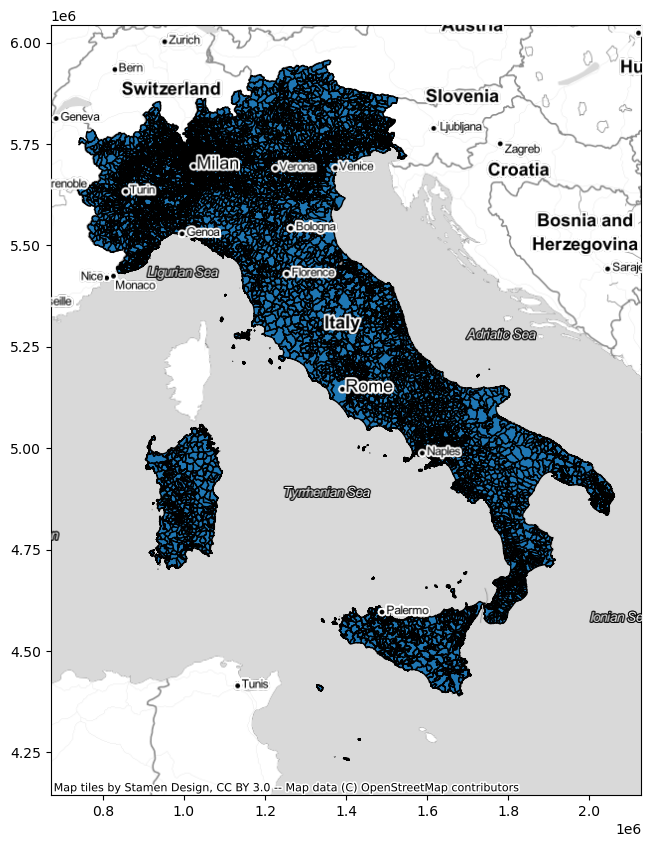

In [324]:
show_map(municipality_gdf)

Map of town halls available on OSM:

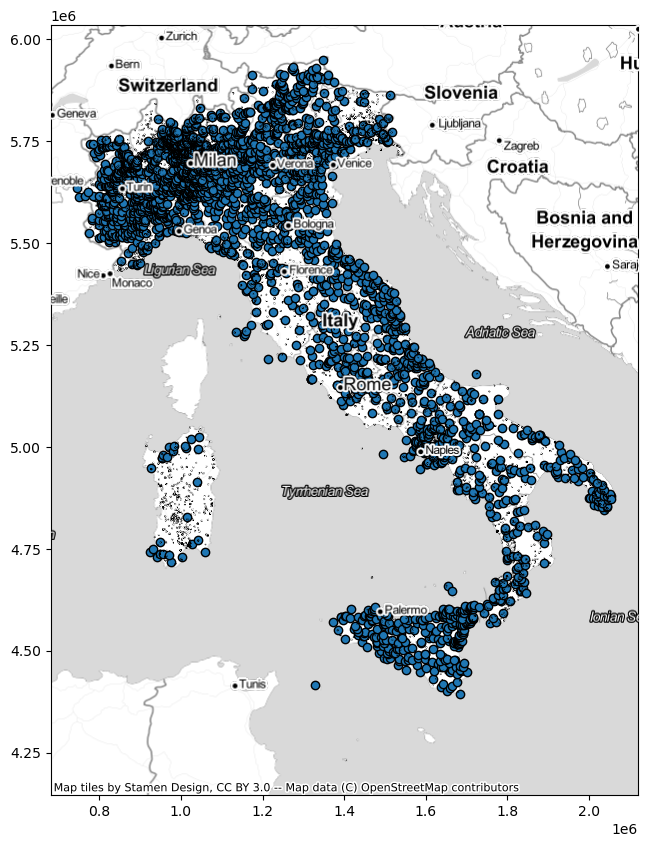

In [325]:
show_map(townhall_gdf)
#show_map(townhall_gdf, municipality_gdf)
#municipality_gdf.explore()
#townhall_gdf.explore()

### Find municipalities without town halls

In [326]:
with_townhall_gdf = townhall_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
with_townhall_gdf.count()

id_hall          7319
osm_id_hall      7319
osm_type_hall    7319
osm_url_hall     7319
name_hall        5765
geometry         7319
index_town       7319
id_town          7319
osm_id_town      7319
osm_type_town    7319
osm_url_town     7319
name_town        7319
dtype: int64

In [327]:
without_townhall_gdf = municipality_gdf[ # Anti-join
        ~municipality_gdf["id"].isin(with_townhall_gdf["id_town"])
    ]
without_townhall_gdf.to_file(WITHOUT_TOWNHALL_FILE_PATH, driver="GeoJSON")
without_townhall_gdf.count()

id          1231
osm_id      1231
osm_type    1231
osm_url     1231
name        1231
geometry    1231
dtype: int64

In [328]:
without_townhall_gdf.head()

id    osm_id  osm_type                                          osm_url  \
27    28     39855  relation     https://www.openstreetmap.org/relation/39855   
44    45     39803  relation     https://www.openstreetmap.org/relation/39803   
185  186  12338682  relation  https://www.openstreetmap.org/relation/12338682   
426  427     40827  relation     https://www.openstreetmap.org/relation/40827   
453  454     40950  relation     https://www.openstreetmap.org/relation/40950   

                                               name  \
27                   Bidda Matzràxia/Villamassargia   
44                         Sa Baronia/Villaperuccio   
185                                     Misiliscemi   
426                           Caragnani/Calangianus   
453  Sant'Antoni di Gaddura/Sant'Antonio di Gallura   

                                              geometry  
27   MULTIPOLYGON (((8.73100 39.28096, 8.73147 39.2...  
44   MULTIPOLYGON (((8.61680 39.12812, 8.61717 39.1...  
185  MULTIPOLYGON (((12.49852 37.96577, 12.50396 37...  
426  MULTIPOLYGON (((9.30121 40.84693, 9.30056 40.8...  
453  MULTIPOLYGON (((9.31750 40.92267, 9.31720 40.9...

Map of municipalities without town hall:

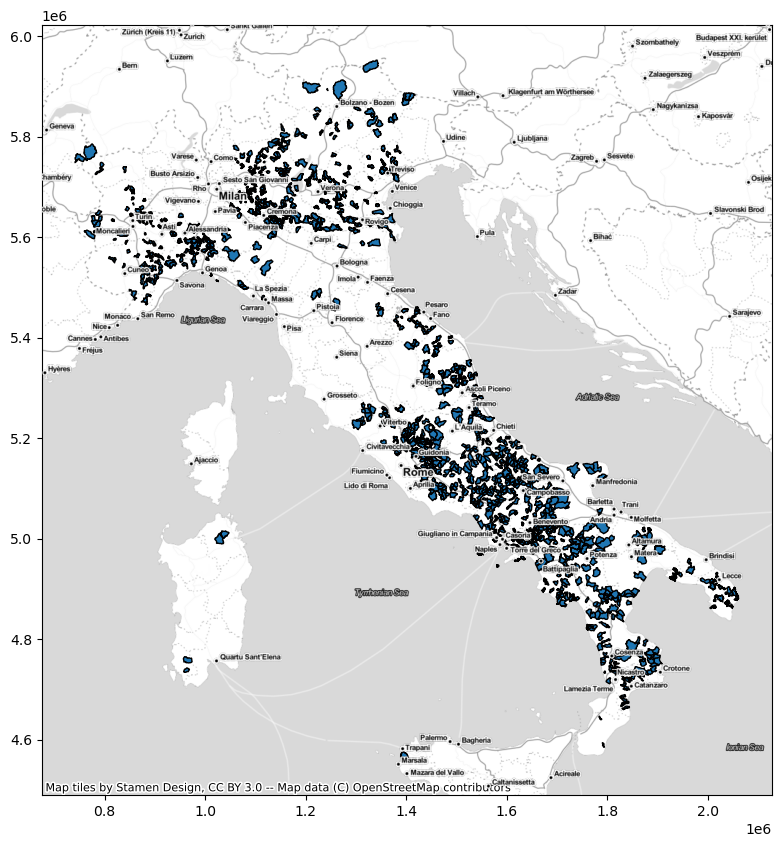

In [329]:
show_map(without_townhall_gdf)
#without_townhall_gdf.explore()

### Calculate statistics for each province

In [330]:
province_municipality_df = province_gdf[["id","geometry"]].sjoin(
        municipality_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_municipalities"] = province_municipality_df.groupby(province_municipality_df.index).count()["index_mun"]

In [331]:
province_without_townhall_df = province_gdf[["id","geometry"]].sjoin(
        without_townhall_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_without_townhall"] = province_without_townhall_df.groupby(province_without_townhall_df.index).count()["index_mun"]

<Axes: >

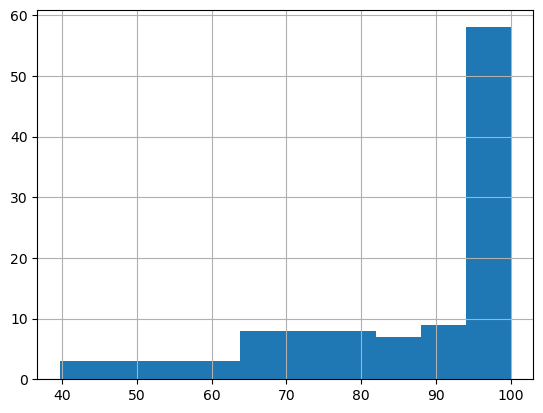

In [332]:
province_gdf["osm_availability"] = 100 * (1 - (province_gdf["num_without_townhall"] / province_gdf["num_municipalities"]))
province_gdf["osm_availability"].hist()

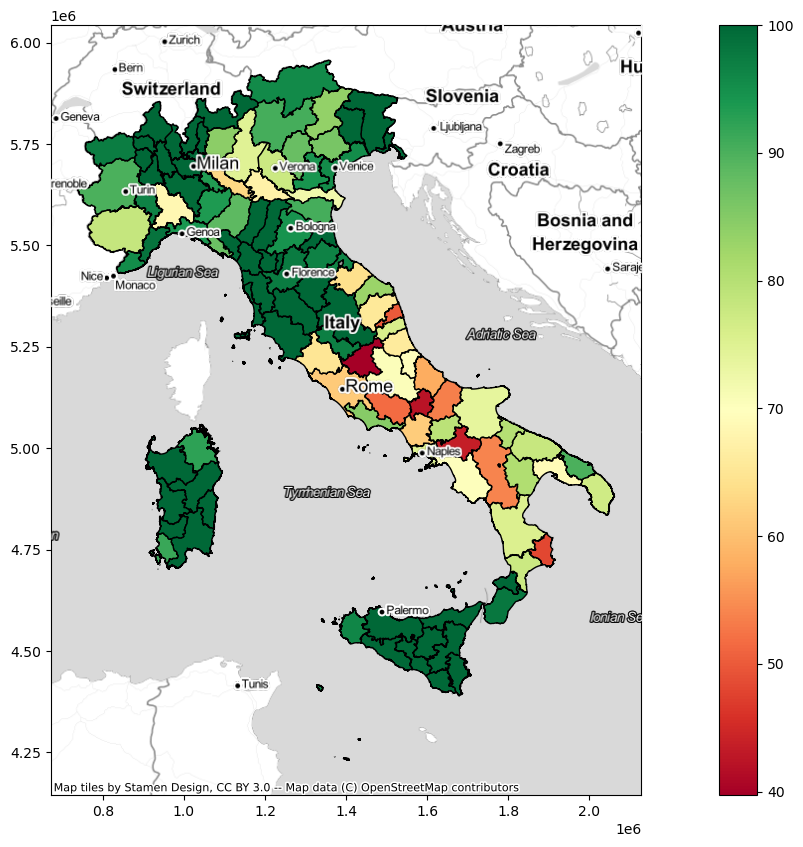

In [333]:
show_map(province_gdf, None, "osm_availability", "RdYlGn")

### Find OSM untagged building named as town halls

In [334]:
UNTAGGED_OVERPASS_QUERY=f"""
[out:json][timeout:300];
area({SEARCH_AREA_ID})->.searchArea;
nwr["building"]["amenity"!="townhall"]["name"~"^(\s|palazzo|del|nuovo|comune|-)*municipio",i](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""
untagged_gdf = readOrFetchOverpassGeoDataFrame(UNTAGGED_FILE_PATH, UNTAGGED_OVERPASS_QUERY)
untagged_gdf.count()

id          30
osm_id      30
osm_type    30
osm_url     30
name        30
geometry    30
dtype: int64

In [335]:
untagged_gdf.head()

id      osm_id osm_type                                       osm_url  \
0   1   277834707      way   https://www.openstreetmap.org/way/277834707   
1   2   933053288      way   https://www.openstreetmap.org/way/933053288   
2   3   332108931      way   https://www.openstreetmap.org/way/332108931   
3   4    60145522      way    https://www.openstreetmap.org/way/60145522   
4   5  1141570499      way  https://www.openstreetmap.org/way/1141570499   

                                    name  \
0                Municipio di Monserrato   
1                              Municipio   
2  Municipio Roma V - Sala del Consiglio   
3                              Municipio   
4            Municipio di Montecastrilli   

                                            geometry  
0  LINESTRING (9.14363 39.25416, 9.14336 39.25394...  
1  LINESTRING (13.09184 37.95253, 13.09212 37.952...  
2  LINESTRING (12.54286 41.88062, 12.54275 41.880...  
3  LINESTRING (12.95500 41.58178, 12.95523 41.581...  
4  LINESTRING (12.48795 42.64981, 12.48778 42.649...

In [336]:
untagged_missing_gdf = untagged_gdf.sjoin(
        without_townhall_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
untagged_missing_gdf.count()

id_hall          2
osm_id_hall      2
osm_type_hall    2
osm_url_hall     2
name_hall        2
geometry         2
index_town       2
id_town          2
osm_id_town      2
osm_type_town    2
osm_url_town     2
name_town        2
dtype: int64

In [337]:
untagged_missing_gdf.head()

id_hall osm_id_hall osm_type_hall  \
4         5  1141570499           way   
10       11   672589063           way   

                                    osm_url_hall  \
4   https://www.openstreetmap.org/way/1141570499   
10   https://www.openstreetmap.org/way/672589063   

                                  name_hall  \
4               Municipio di Montecastrilli   
10  Municipio di Atella di Napoli (1928-46)   

                                             geometry  index_town  id_town  \
4   LINESTRING (12.48795 42.64981, 12.48778 42.649...         874      875   
10  LINESTRING (14.26055 40.96097, 14.26056 40.961...        1834     1835   

   osm_id_town osm_type_town                                  osm_url_town  \
4        42101      relation  https://www.openstreetmap.org/relation/42101   
10       40939      relation  https://www.openstreetmap.org/relation/40939   

         name_town  
4   Montecastrilli  
10     Sant'Arpino

In [338]:
untagged_missing_gdf.to_file(UNTAGGED_MISSING_FILE_PATH, driver='GeoJSON')

In [339]:
#show_map(untagged_missing_gdf)
untagged_missing_gdf.explore()

### Find elements wrongly mapped as town halls

In [340]:
bad_townhall_mask = Series(False, index=townhall_gdf.index)
for word in ["consorzio","uffici"]:
    bad_townhall_mask |= townhall_gdf["name"].str.lower().str.contains(word, na=False)
bad_townhall_mask.value_counts()

False    7274
True       39
dtype: int64

In [341]:
bad_townhall_gdf = townhall_gdf[bad_townhall_mask]
bad_townhall_gdf.to_file(BAD_TOWNHALLS_FILE_PATH, driver='GeoJSON')
bad_townhall_gdf.explore()

## Step 2: Obtain the data from DBSN

Download the data from IGM DBSN ( https://www.igmi.org/it/dbsn-database-di-sintesi-nazionale ).

Then extract the catageory of elements you are interested in and save it as GeoJSON with EPSG 4326 SRID.
To accomplish you can use the script "filtra_dbsn.sh" in the project repository root (or https://www.dsantini.it/dbsn/filtra_dbsn.sh ).
The file downloaded below from dbsn_url has been generated with this script. 

## Step 3: Analyse useful data from DBSN

### Find possible town halls from DBSN

#### Download DBSN data on town halls

In [342]:
def download_file_if_not_exists(file_path, url):
    if not exists(file_path):
        try: 
            urlretrieve(url, file_path)
        except HTTPError as err:
            print("Failed downloading data from Overpass, retry later")
            raise err

In [343]:
# https://www.dsantini.it/dbsn/
dbsn_url = "https://www.dsantini.it/dbsn/notebooks/dbsn_townhalls.geojson"
download_file_if_not_exists(DBSN_FILE_PATH, dbsn_url)

In [344]:
dbsn_gdf = read_file(DBSN_FILE_PATH)
dbsn_gdf.count()


edifc_uso       8382
edifc_ty        8382
edifc_sot       8382
classid         8354
edifc_nome      8381
edifc_stat      8382
edifc_at        8321
scril           8055
meta_ist        8367
edifc_mon       8382
shape_Length    8382
shape_Area      8382
geometry        8382
dtype: int64

In [345]:
dbsn_gdf.head()

edifc_uso edifc_ty edifc_sot                               classid  \
0      0201       93        93  65D8ED81-5047-4CEA-9103-AA2034B665DD   
1      0201       93        93  D659C260-EDD5-4540-BC6C-EACB33EC447B   
2      0201       93        93  b4949764-f626-442c-89ad-200e56ea653d   
3      0201       93        93  ece5bd6f-834b-4230-a100-89232be50ff0   
4      0201       93        93  7c14edd9-e910-4de2-9cb9-2cc44be6a4fc   

                        edifc_nome edifc_stat  edifc_at scril meta_ist  \
0  Municipio di Lampedusa e Linosa         91   -9999.0   10k       04   
1              Municipio di Licata         91   -9999.0   10k       04   
2           Municipio di Cammarata         91   -9999.0   10k       04   
3  Municipio di San Biagio Platani         91   -9999.0   10k       04   
4           Municipio di Cianciana         91   -9999.0   10k       04   

  edifc_mon  shape_Length  shape_Area  \
0        02     66.022667  272.435503   
1        02     99.677476  358.678321   
2        02    133.927947  670.469227   
3        02    134.259563  628.250694   
4        02    126.859157  633.197564   

                                            geometry  
0  MULTIPOLYGON Z (((12.60941 35.50254 0.00000, 1...  
1  MULTIPOLYGON Z (((13.93720 37.10145 0.00000, 1...  
2  MULTIPOLYGON Z (((13.63779 37.63324 0.00000, 1...  
3  MULTIPOLYGON Z (((13.52434 37.50919 0.00000, 1...  
4  MULTIPOLYGON Z (((13.43422 37.51843 0.00000, 1...

#### Town statistics for DBSN

In [346]:
municipality_dbsn_gdf = municipality_gdf[["id","geometry"]].sjoin(
        dbsn_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="mun",
        rsuffix="dbsn"
    )
municipality_gdf["dbsn_townhall_num"] = municipality_dbsn_gdf.groupby(municipality_dbsn_gdf.index).count()["index_dbsn"]

<Axes: >

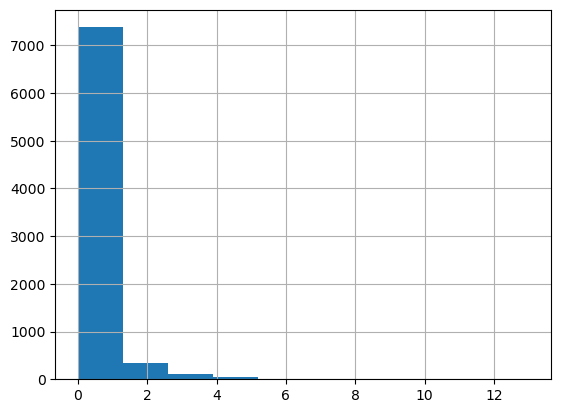

In [347]:
municipality_gdf["dbsn_townhall_num"].hist()

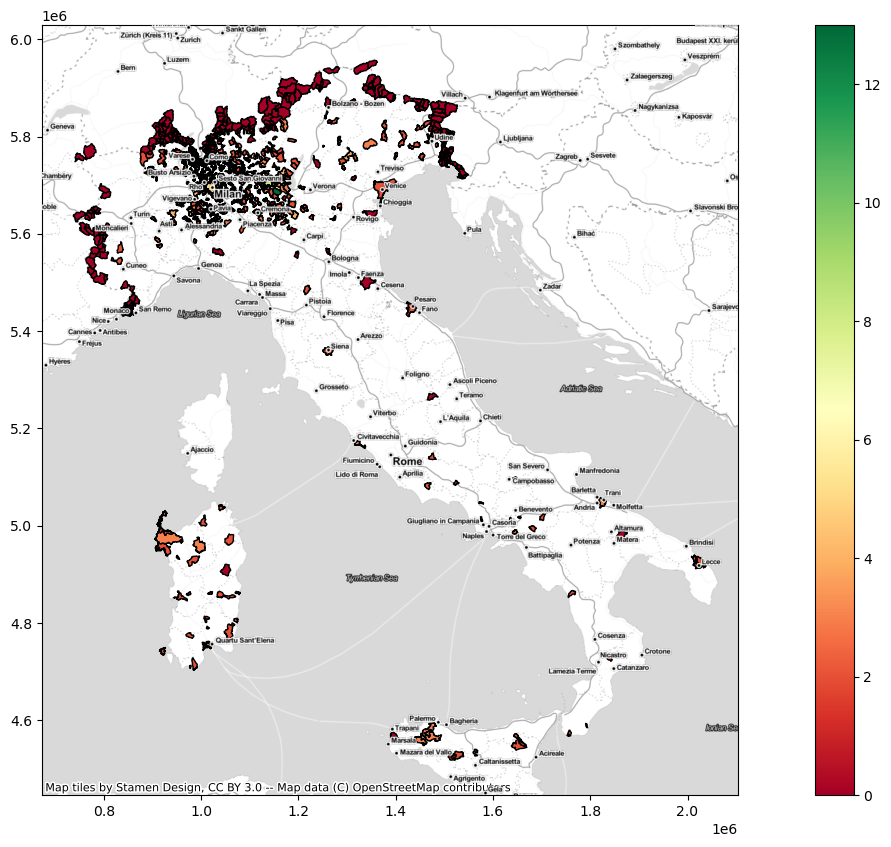

In [348]:
show_map(municipality_gdf[municipality_gdf["dbsn_townhall_num"] != 1], None, "dbsn_townhall_num", "RdYlGn")

#### Province statistics for DBSN

In [349]:
province_dbsn_df = province_gdf[["id","geometry"]].sjoin(
        dbsn_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="dbsn"
    )
province_gdf["dbsn_townhall_num"] = province_dbsn_df.groupby(province_dbsn_df.index).count()["index_dbsn"]

<Axes: >

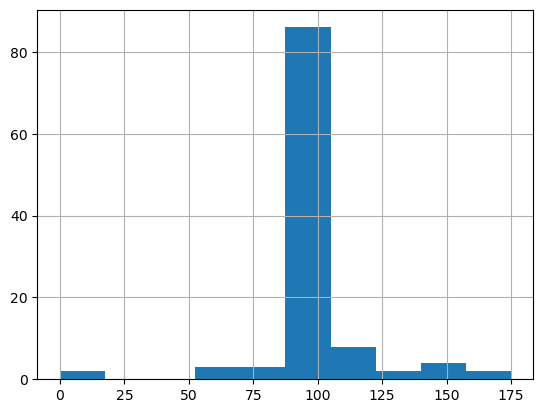

In [350]:
province_gdf["dbsn_availability"] = (100 * (province_gdf["dbsn_townhall_num"] / province_gdf["num_municipalities"])).astype(int)
province_gdf["dbsn_availability"].hist()

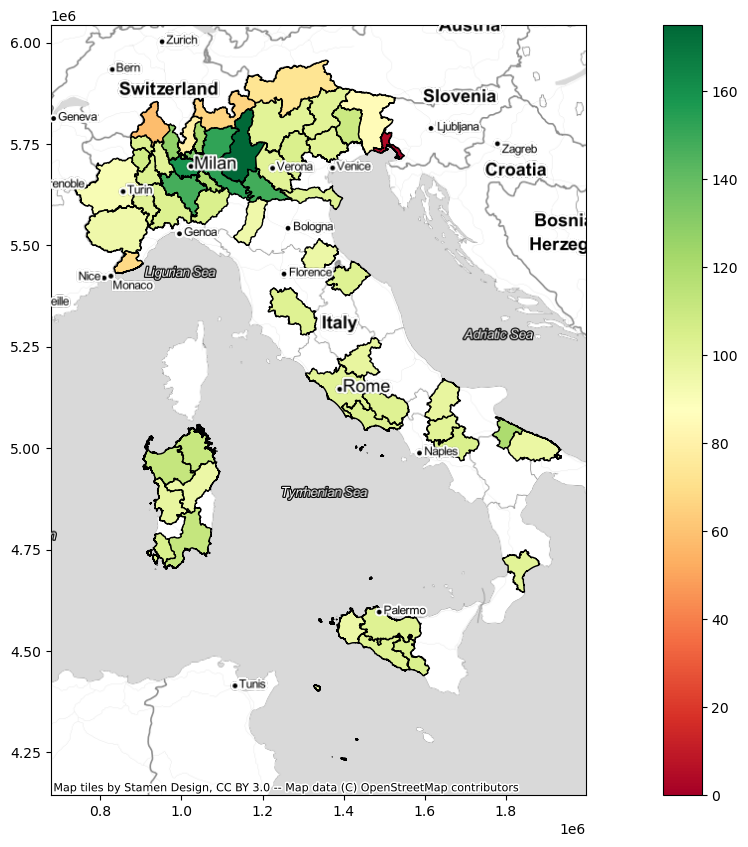

In [367]:
show_map(province_gdf[province_gdf["dbsn_availability"] != 100], None, "dbsn_availability", "RdYlGn")

In [366]:
province_gdf[["id","name","dbsn_townhall_num","num_municipalities","dbsn_availability"]].to_csv("province_stats.csv")

#### Compare existing town halls from OSM and DBSN

In [352]:
dbsn_existing_df = dbsn_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="dbsn",
        rsuffix="town"
    )
dbsn_existing_df.count()

edifc_uso            8374
edifc_ty             8374
edifc_sot            8374
classid              8360
edifc_nome           8373
edifc_stat           8374
edifc_at             8327
scril                8060
meta_ist             8373
edifc_mon            8374
shape_Length         8374
shape_Area           8374
geometry             8374
index_town           8374
id                   8374
osm_id               8374
osm_type             8374
osm_url              8374
name                 8374
dbsn_townhall_num    8374
dtype: int64

In [353]:
compare_gdf = merge(
    dbsn_existing_df,
    with_townhall_gdf,
    how="inner",
    left_on="index_town",
    right_on="index_town"
)
compare_gdf.count()

edifc_uso            7838
edifc_ty             7838
edifc_sot            7838
classid              7829
edifc_nome           7837
edifc_stat           7838
edifc_at             7794
scril                7496
meta_ist             7833
edifc_mon            7838
shape_Length         7838
shape_Area           7838
geometry_x           7838
index_town           7838
id                   7838
osm_id               7838
osm_type             7838
osm_url              7838
name                 7838
dbsn_townhall_num    7838
id_hall              7838
osm_id_hall          7838
osm_type_hall        7838
osm_url_hall         7838
name_hall            6279
geometry_y           7838
id_town              7838
osm_id_town          7838
osm_type_town        7838
osm_url_town         7838
name_town            7838
dtype: int64

In [354]:
compare_gdf["distance"] = compare_gdf["geometry_x"].to_crs(epsg=3857).distance(
    compare_gdf["geometry_y"].to_crs(epsg=3857)
  )
compare_gdf["geometry"] = compare_gdf.apply(
    lambda row: LineString([row['geometry_x'].centroid, row['geometry_y'].centroid]),
    axis=1
  ).set_crs(epsg=4326)

array([[<Axes: title={'center': 'distance'}>]], dtype=object)

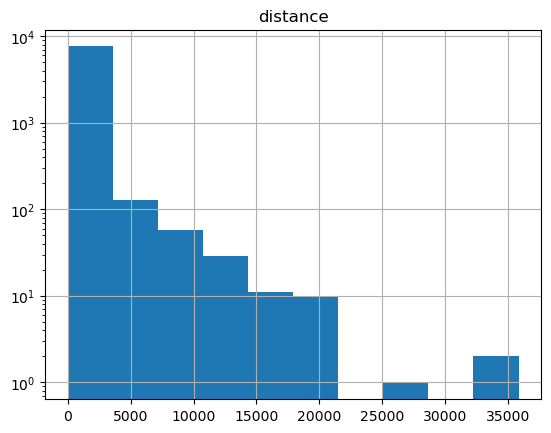

In [355]:
compare_gdf.hist(log=True, column="distance")

In [356]:
conflict_mask=compare_gdf["distance"] > 1000
for word in [
        "delegazione",
        "circoscrizione",
        "quartiere",
        "frazione",
        "municipalit",
        "municipio roma",
        "consorzio",
        "° municipio",
        "uffici",
        "sede di",
        "distaccat"
    ]:
    conflict_mask &= ~(compare_gdf["name_hall"].str.lower().str.contains(word, na=False))
conflict_mask.value_counts()

False    7489
True      349
Name: distance, dtype: int64

In [357]:
dbsn_conflict_gdf = compare_gdf[conflict_mask]
dbsn_conflict_gdf["name_hall"].dropna().drop_duplicates()

87                      Municipio di Alluvioni Piovera
88                                Municipio di Piovera
131               Municipio di Lu e Cuccaro Monferrato
408     Comune dell'Aquila Ricostruzione Beni Pubblici
410               Comune dell'Aquila Equità tributaria
                             ...                      
7582                      Sede Municipale di Colceresa
7606             Ex municipio di Campolongo sul Brenta
7617                        Municipio di Lusiana Conco
7669            Comune di Verona - Edilizia Scolastica
7784                                  Comune di Ionadi
Name: name_hall, Length: 177, dtype: object

In [358]:
dbsn_conflict_gdf.explore()

In [359]:
dbsn_conflict_gdf.drop(["geometry_x", "geometry_y"], axis=1).to_file(DBSN_CONFLICTS_FILE_PATH, driver="GeoJSON")

#### Getting missing town halls from Public Data

In [360]:
dbsn_missing_df = dbsn_gdf.sjoin(
    without_townhall_gdf,
    how="inner",
    predicate="within"
)
dbsn_missing_df.count()

edifc_uso       1278
edifc_ty        1278
edifc_sot       1278
classid         1273
edifc_nome      1278
edifc_stat      1278
edifc_at        1273
scril           1255
meta_ist        1278
edifc_mon       1278
shape_Length    1278
shape_Area      1278
geometry        1278
index_right     1278
id              1278
osm_id          1278
osm_type        1278
osm_url         1278
name            1278
dtype: int64

In [361]:
dbsn_missing_df.head()

edifc_uso edifc_ty edifc_sot                               classid  \
48      0201       01        01  e6635754-4083-4030-8ceb-77084f2c9ba3   
49      0201       01        01  93480b43-8fd4-49be-a7f0-c85487b62546   
50      0201       01        01  5d77b0ec-1cc8-491e-8a92-425b38cb3111   
52      0201       01        01  94106d54-3dd9-422e-9199-93b079e01f6c   
53      0201       01        01  287da1e2-505b-4295-b484-9e3ec07571c5   

                          edifc_nome edifc_stat  edifc_at  \
48              Municipio di PADERNA         03   -9999.0   
49           Municipio di MONTEGIOCO         03   -9999.0   
50  Municipio di CASTELLAR GUIDOBONO         03   -9999.0   
52         Municipio di VILLALVERNIA         03   -9999.0   
53              Municipio di DERNICE         03   -9999.0   

                                                scril meta_ist edifc_mon  \
48  1:2000                                        ...       04        02   
49  1:2000                                        ...       04        02   
50  1:2000                                        ...       04        02   
52  1:2000                                        ...       04        02   
53  1:2000                                        ...       04        02   

    shape_Length  shape_Area  \
48     76.283735  210.957406   
49     45.669440  129.941911   
50     46.584363  123.354444   
52     92.197220  387.012599   
53     48.885326   84.226670   

                                             geometry  index_right    id  \
48  MULTIPOLYGON Z (((8.89020 44.82071 0.00000, 8....         3852  3853   
49  MULTIPOLYGON Z (((8.95418 44.83776 0.00000, 8....         3839  3840   
50  MULTIPOLYGON Z (((8.94677 44.90624 0.00000, 8....         3857  3858   
52  MULTIPOLYGON Z (((8.85671 44.81768 0.00000, 8....         3837  3838   
53  MULTIPOLYGON Z (((9.04985 44.76721 0.00000, 9....         3830  3831   

   osm_id  osm_type                                       osm_url  \
48  43685  relation  https://www.openstreetmap.org/relation/43685   
49  43687  relation  https://www.openstreetmap.org/relation/43687   
50  43791  relation  https://www.openstreetmap.org/relation/43791   
52  43637  relation  https://www.openstreetmap.org/relation/43637   
53  43572  relation  https://www.openstreetmap.org/relation/43572   

                   name  
48              Paderna  
49           Montegioco  
50  Castellar Guidobono  
52         Villalvernia  
53              Dernice

In [362]:
dbsn_missing_df.to_file(DBSN_MISSING_FILE_PATH, driver="GeoJSON")

In [363]:
#%pip install folium matplotlib mapclassify
dbsn_missing_df.explore()